# Sentiment Analysis using doc vector and RegularNet in Keras

In [1]:
# CONFIGS

h5_save_as = "models/ffnn-dbow.h5"

# Must be a doc2vec model file, not a word2vec bin/txt as it does not preserve document vectors.
doc2vec_model_file = "word2vec/d2v-dbow-not-padded-100d.model"
doc2vec_dims = 100

# Can easily swap with other datasets if you want
positive_review_txts = "aclImdb/train/pos/*.txt"
negative_review_txts = "aclImdb/train/neg/*.txt"
positive_review_vals = "aclImdb/test/pos/*.txt"
negative_review_vals = "aclImdb/test/neg/*.txt"
# positive_review_txts = "polarity2/txt_sentoken/pos/*.txt"
# negative_review_txts = "polarity2/txt_sentoken/neg/*.txt"
# positive_review_vals = "polarity2/txt_sentoken/pos/*.txt"
# negative_review_vals = "polarity2/txt_sentoken/neg/*.txt"

positive_y = [1, 0]
negative_y = [0, 1]

# Test theano and graphics card
import theano.tensor as T

# Notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from text_tokenizer import tokenize

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5105)
/home/anonoz/anaconda2/envs/tensorflow/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Step 1: Make X_train

X_train data structure is a 3D array, consisting of reviews, words, and vectors:
```json
[
  // a review
  [
    // a word, and its array of 100 vectors
    [0.75, 0.64 ...],
    ...
  ], 
  ...
]
```

### TODO:
1. Load all the reviews into memory
2. Normalize the text
3. Add words to vocab array to make word vector retrieval faster
3. Determine vocab size, max review length

('highest word count: ', 2606)
('mean of review length: ', 253.51831999999999)


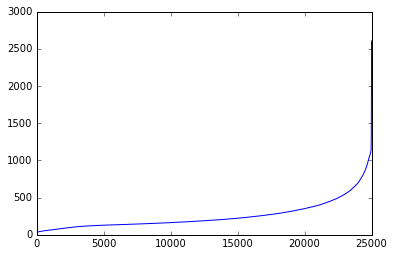

In [2]:
import glob

# highest word count shall be the convnet rows
highest_review_word_count = 0
positive_reviews = []
negative_reviews = []
positive_testrev = []
negative_testrev = []

# to visualise review length
training_review_length = []

for txt in glob.glob(positive_review_txts):
    with (open(txt, 'r')) as f:
        word_array = tokenize(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        positive_reviews.append(word_array)
        training_review_length.append(len(word_array))

for txt in glob.glob(negative_review_txts):
    with (open(txt, 'r')) as f:
        word_array = tokenize(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        negative_reviews.append(word_array)
        training_review_length.append(len(word_array))
        
# For validation purposes
for txt in glob.glob(positive_review_vals):
    with (open(txt, 'r')) as f:
        word_array = tokenize(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        positive_testrev.append(word_array)

for txt in glob.glob(negative_review_vals):
    with (open(txt, 'r')) as f:
        word_array = tokenize(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        negative_testrev.append(word_array)

print('highest word count: ', highest_review_word_count)

# Plotting length
training_review_length = np.sort(np.array(training_review_length))
print('mean of review length: ', np.mean(training_review_length))
plt.plot(training_review_length)

## Step 2: Infer vector from doc2vec

In [3]:
import sys
import gensim
from gensim.models import Doc2Vec
doc2vec_model = Doc2Vec.load(doc2vec_model_file)

In [4]:
log_counter = 0

X_train = []
Y_train = []
X_test  = []
Y_test  = []

# Due to memory constraint, we only take vectors for first 200 words in movie reviews
for i, review in enumerate(positive_reviews):
    X_train.append(doc2vec_model.infer_vector(review))
    Y_train.append(positive_y)
    log_counter += 1
    if log_counter % 1000 == 0:
        sys.stdout.write("\r{0}".format(log_counter))
        sys.stdout.flush()
    
for i, review in enumerate(negative_reviews):
    X_train.append(doc2vec_model.infer_vector(review))
    Y_train.append(negative_y)
    log_counter += 1
    if log_counter % 1000 == 0:
        sys.stdout.write("\r{0}".format(log_counter))
        sys.stdout.flush()
    
# For validation purposes
for i, review in enumerate(positive_testrev):
    X_test.append(doc2vec_model.infer_vector(review))
    Y_test.append(positive_y)
    log_counter += 1
    if log_counter % 1000 == 0:
        sys.stdout.write("\r{0}".format(log_counter))
        sys.stdout.flush()
    
for i, review in enumerate(negative_testrev):
    X_test.append(doc2vec_model.infer_vector(review))
    Y_test.append(negative_y)
    log_counter += 1
    if log_counter % 1000 == 0:
        sys.stdout.write("\r{0}".format(log_counter))
        sys.stdout.flush()

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test  = np.array(X_test)
Y_test  = np.array(Y_test)

50000

## Step 3: Keras


In [5]:
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution1D, Convolution2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D
from keras.layers import Merge, Dense, Dropout, Activation, Input, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

Using Theano backend.


In [9]:
final_model = Sequential()
final_model.add(Dense(32, input_shape=(doc2vec_dims,)))
final_model.add(Activation('relu'))
final_model.add(Dropout(0.5))
final_model.add(Dense(2))
final_model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
final_model.compile(loss='binary_crossentropy',
                    optimizer='rmsprop',
                    metrics=['accuracy'])


## Step 4: TRAIN THIS

In [10]:
model_callback = ModelCheckpoint(
    h5_save_as,
    save_best_only=True,
    verbose=1
)

In [11]:
final_model.fit(X_train,
                Y_train,
                batch_size=50,
                nb_epoch=25,
                callbacks=[model_callback],
                validation_data=[X_test, Y_test])

Train on 25000 samples, validate on 25000 samples
Epoch 1/25
25000/25000 [==============================] - 1s - loss: 0.4534 - acc: 0.7837 - val_loss: 0.3334 - val_acc: 0.8574
Epoch 2/25
25000/25000 [==============================] - 1s - loss: 0.3451 - acc: 0.8539 - val_loss: 0.3234 - val_acc: 0.8620
Epoch 3/25
25000/25000 [==============================] - 2s - loss: 0.3317 - acc: 0.8628 - val_loss: 0.3224 - val_acc: 0.8622
Epoch 4/25
25000/25000 [==============================] - 1s - loss: 0.3251 - acc: 0.8669 - val_loss: 0.3210 - val_acc: 0.8629
Epoch 5/25
25000/25000 [==============================] - 1s - loss: 0.3206 - acc: 0.8685 - val_loss: 0.3197 - val_acc: 0.8630
Epoch 6/25
25000/25000 [==============================] - 1s - loss: 0.3165 - acc: 0.8718 - val_loss: 0.3195 - val_acc: 0.8646
Epoch 7/25
25000/25000 [==============================] - 1s - loss: 0.3148 - acc: 0.8725 - val_loss: 0.3189 - val_acc: 0.8654
Epoch 8/25
25000/25000 [==============================] - 1s 